In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from glob import glob

# tensorflow keras
from tensorflow.keras import Sequential, layers, callbacks, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Rescaling

import tensorflow as tf
from tensorflow.io import decode_jpeg, read_file
from tensorflow.image import resize
from tensorflow.data import AUTOTUNE, Dataset

# Data Preparation

Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_dir = '/content/drive/My Drive/Colab Notebooks/melanoma_project/'
meta = pd.read_csv(base_dir+'raw_data/HAM10000_metadata.csv')
meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## Image paths to metadata

In [4]:
base_skin_dir = os.path.join(base_dir,'raw_data')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir,'**', '*.jpg'),recursive=True)}

meta['path'] = meta['image_id'].map(imageid_path_dict.get)

## Custom functions

Dataset manipulation

In [5]:
def data_balancer(df):
    '''Returns a metadata set with equal number of melanoma and nevi observations'''
    mel_df = df.query('dx == "mel"')
    rest_df = df.query('dx == "nv"')
    #randomly takes indexes equal number of melanoma observations
    idx_nonmel = np.random.choice(list(rest_df.index), len(mel_df)) 
    non_mel_balanced = df.iloc[idx_nonmel]
    balanced_meta = pd.concat([non_mel_balanced,mel_df], axis=0)
    return balanced_meta

In [6]:
def reduce_set(df, reduction_factor = 10):
    '''Reduces dataset size by the reduction factor'''
    # Choosing the random indices of small train set and small test set
    idx =  np.random.choice(len(df), round(len(df)/reduction_factor))
    # Collecting the two subsamples images_train_small and images_test_small from images_train and images_test
    reduced_df = df.iloc[idx]
    return reduced_df 

Tensorflow image extraction

In [7]:
def decode_resize(img,img_height, img_width):
    '''Decodes JPG img=image and resizes to img_height=180, img_width=240.
    Returns a uint8 resize image'''
    # Convert the compressed string to a 3D uint8 tensor
    img = decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    img = resize(img, [img_height, img_width])
    return tf.cast(img, tf.uint8)

In [8]:
def get_image_and_label(pathdx):
    '''Returns decoded image and its corresponding binary encoded 
    classification.'''
    img = read_file(pathdx[0])
    if pathdx[1] == 'mel':
        label = 1
    else:
        label = 0
    return decode_resize(img,img_height=180, img_width=240), label


In [9]:
def prepare_dataset(df):
    '''Prepares a tensorflow dataset with image path and classification and gets
    the decoded and resized image with its classification. Optimizes the mapping 
    with parallel calls tf.data.AUTOTUNE
    Returns a tf.parallelMapDataset'''
    list_ds = Dataset.from_tensor_slices(df[['path','dx']])
    tf_ds = list_ds.map(get_image_and_label, num_parallel_calls=AUTOTUNE)
    return tf_ds

Train validation split

In [10]:
def tf_train_val_split(ds, val_ratio=0.2):
    '''Takes a ds tensorflow.dataset and returns train and validation 
    datasets with a validation ratio val_ratio.'''
    val_size = int(len(ds) * val_ratio)
    train_ds = ds.skip(val_size)
    val_ds = ds.take(val_size)
    return train_ds, val_ds

Optimized perfomance for tensorflow.dataset

In [11]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size=16)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

## Small dataset test 

Prepare a small datset

In [12]:
balanced_meta = data_balancer(meta)
reduced_meta = reduce_set(balanced_meta, reduction_factor=3)
reduced_meta.shape

(742, 8)

In [13]:
small_ds = prepare_dataset(reduced_meta)

In [16]:
for img, label in small_ds.take(1):
    print("Image shape: ", img.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 240, 3)
Label:  0


In [17]:
small_ds = small_ds.shuffle(len(small_ds), reshuffle_each_iteration=False)

In [18]:
train_small, val_small = tf_train_val_split(small_ds,val_ratio=0.2)
train_small = configure_for_performance(train_small)
val_small = configure_for_performance(val_small)

Note: 22 images saved in pickle take 68MB in space.

## Dataset 2k

All melanoma images balanced with equal number (1113) of nevi images

In [29]:
balanced_meta = data_balancer(meta)

In [30]:
2k_ds = prepare_dataset(balanced_meta)

In [ ]:
for img, label in 2k_ds.take(1):
    print("Image shape: ", img.numpy().shape)
    print("Label: ", label.numpy())

In [31]:
2k_ds = 2k_ds.shuffle(len(2k_ds), reshuffle_each_iteration=False)

In [32]:
train_2k, val_2k = tf_train_val_split(2k_ds,val_ratio=0.2)


In [35]:
train_2k = configure_for_performance(train_2k)
val_2k = configure_for_performance(val_2k)

# CNN model

In [19]:
def initialize_model():
    model = Sequential()
    model.add(Rescaling(1./255))
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(180,240,3)))
    model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.16))

    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same'))
    model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.20))

    model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same'))
    model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

In [20]:
def compile(model,learning_rate=0.0003, beta_1=0.9, beta_2=0.999):
    adam_opt = optimizers.Adam(learning_rate=learning_rate, 
                                beta_1=beta_1, beta_2=beta_2)

    model.compile(loss='binary_crossentropy', 
                optimizer=adam_opt,
                metrics=['accuracy'])
    return model

In [21]:
model = initialize_model()

In [22]:
model = compile(model)

In [23]:
# Fit the model. Select corresponding small or 2k_ds
es = callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(train_2k,
                    validation_data=val_2k,
                    epochs=300, 
                    callbacks=[es], 
                    verbose=1)

Epoch 1/300
38/38 [==============================] - 48s 162ms/step - loss: 0.7017 - accuracy: 0.4949 - val_loss: 0.6925 - val_accuracy: 0.5068
Epoch 2/300
38/38 [==============================] - 2s 48ms/step - loss: 0.6978 - accuracy: 0.5118 - val_loss: 0.6930 - val_accuracy: 0.5068
Epoch 3/300
38/38 [==============================] - 2s 48ms/step - loss: 0.6892 - accuracy: 0.5370 - val_loss: 0.6636 - val_accuracy: 0.6554
Epoch 4/300
38/38 [==============================] - 2s 48ms/step - loss: 0.6216 - accuracy: 0.6330 - val_loss: 0.5765 - val_accuracy: 0.7500
Epoch 5/300
38/38 [==============================] - 2s 50ms/step - loss: 0.5506 - accuracy: 0.7121 - val_loss: 0.5664 - val_accuracy: 0.7432
Epoch 6/300
38/38 [==============================] - 2s 48ms/step - loss: 0.5664 - accuracy: 0.7088 - val_loss: 0.5445 - val_accuracy: 0.7770
Epoch 7/300
38/38 [==============================] - 2s 48ms/step - loss: 0.5651 - accuracy: 0.7104 - val_loss: 0.4929 - val_accuracy: 0.7568
Epoc

In [24]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

adam learning rate 0.0003, batch_size=16, patience=20 👇 without last conv2d layer set




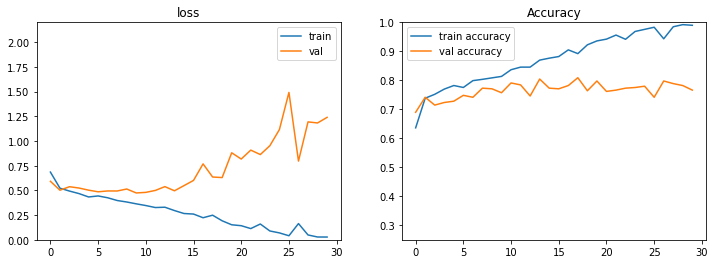

In [47]:
plot_history(history);

learning_rate=0.0003, batch=16, patience=20 👇

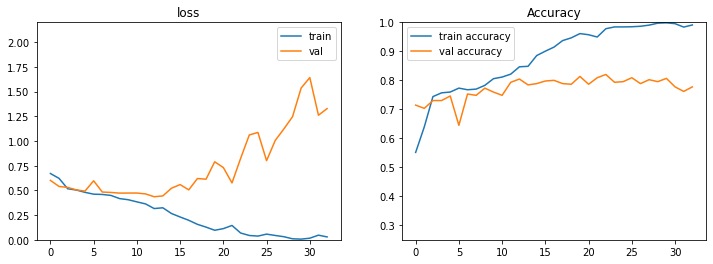

In [41]:
plot_history(history);

# Simple CNN

In [25]:
def initialize_model():
    
    model = Sequential()
    model.add(Rescaling(1./255))
    # model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(180,240,3)))
    # model.add(MaxPooling2D(pool_size = (2, 2)))
    # model.add(Dropout(0.16))

    # model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same'))
    # model.add(MaxPooling2D(pool_size = (2, 2)))
    # model.add(Dropout(0.20))

    # model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same'))
    # model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64, activation='relu',input_shape=(180,240,3)))
    model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
    # model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

In [26]:
def compile(model,learning_rate=0.0003, beta_1=0.9, beta_2=0.999):
  adam_opt = optimizers.Adam(learning_rate=learning_rate, 
                             beta_1=beta_1, beta_2=beta_2)

  model.compile(loss='binary_crossentropy', 
              optimizer=adam_opt,
              metrics=['accuracy'])
  return model

In [27]:
model = initialize_model()


In [28]:
model = compile(model)

In [29]:
es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)

history = model.fit(train_2k,
                    validation_data=val_2k,
                    epochs=200,    
                    callbacks=[es],
                    verbose=1)

Epoch 1/200
38/38 [==============================] - 1s 11ms/step - loss: 0.6939 - accuracy: 0.4882 - val_loss: 0.6884 - val_accuracy: 0.5000
Epoch 2/200
38/38 [==============================] - 0s 7ms/step - loss: 0.6958 - accuracy: 0.5034 - val_loss: 0.6906 - val_accuracy: 0.4932
Epoch 3/200
38/38 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5118 - val_loss: 0.6812 - val_accuracy: 0.7365
Epoch 4/200
38/38 [==============================] - 0s 7ms/step - loss: 0.6690 - accuracy: 0.6077 - val_loss: 0.6177 - val_accuracy: 0.6419
Epoch 5/200
38/38 [==============================] - 0s 7ms/step - loss: 0.6367 - accuracy: 0.6397 - val_loss: 0.6492 - val_accuracy: 0.6284
Epoch 6/200
38/38 [==============================] - 0s 7ms/step - loss: 0.5872 - accuracy: 0.6852 - val_loss: 0.5378 - val_accuracy: 0.7365
Epoch 7/200
38/38 [==============================] - 0s 7ms/step - loss: 0.5663 - accuracy: 0.7138 - val_loss: 0.5266 - val_accuracy: 0.7365
Epoch 8/200


CNN Less conv2d complexity

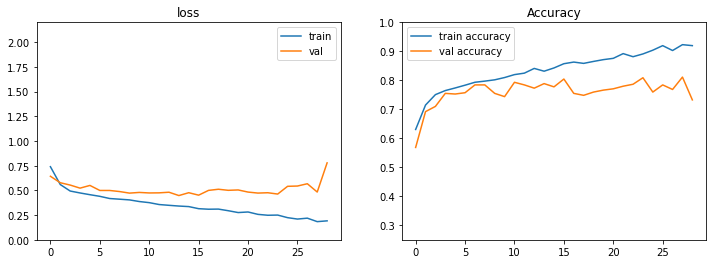

In [55]:
plot_history(history);

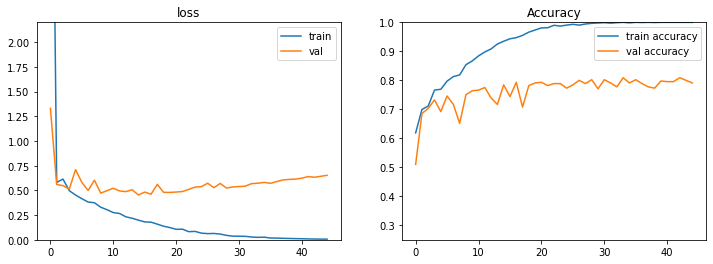

In [61]:
plot_history(history);

Simple four dense hidden layers 64 neurons
- adam learning rate = 0.0003
- batch_size = 16
- patience = 30

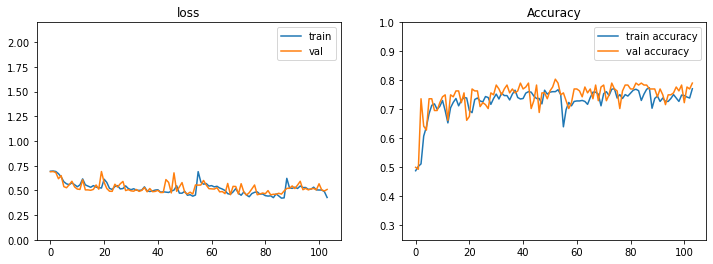

In [30]:
plot_history(history);